In [1]:
import warnings
warnings.filterwarnings('ignore')

import sys
import numpy as np
import copy
import time
import random
import mkl

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

%matplotlib inline

In [2]:
sys.path.append('../src/')

from entropy import Entropy
from rand import Random
from single_policy import Single_policy
from fal import Fal
from decouple import Decouple
from falcon import Combined
from utils import *

pip install 'aif360[LawSchoolGPA]'


# Load fairness dataset from Folktables and AIF360 and define variabels

## 1. Dataset = TravelTime, Employ, Income, COMPAS
## 2. Fairness measure = DP, EO, ED, PP, EER
## 3. ML model = LogisticRegression, NeuralNetwork

In [3]:
mkl.set_num_threads(5) # set the number of threads

dataset_type = "TravelTime" # Employ, Income, COMPAS
target_fairness = "DP" # EO, ED, PP, EER
ml_method = "lr" # nn
num_round, num_examples = 400, 10 # 200, 1 for COMPAS

seed_arr =  [1, 2, 3]
PRINT_RESULT = True

test_acc, test_fairness = dict(), dict()
test_acc_avg, test_acc_std = dict(), dict()
test_fairness_avg, test_fairness_std = dict(), dict()

In [4]:
data, label, z, group_names, train_data_num, test_data_num, un_data_num, val_data_num = load_dataset(dataset_type)

# Single policy baselines in Section 6.4

In [5]:
single_baselines = ["$Pol(0.3)$", "$Pol(0.4)$", "$Pol(0.5)$", "$Pol(0.6)$", "$Pol(0.7)$"]

for method in single_baselines:
    print("=========================")
    print(f"method: {method}")
    
    r = float(method.split("(")[1].split(")")[0])
    test_acc[method] = [[] for _ in range(num_round+1)]
    test_fairness[method] = [[] for _ in range(num_round+1)]
    for seed in seed_arr:
        random.seed(seed)
        np.random.seed(seed)
        
        x_train, y_train, z_train, x_test, y_test, z_test, x_un, y_un, z_un, x_val, y_val, z_val = generate_dataset(data, label, z, train_data_num, test_data_num, un_data_num, val_data_num, seed)
        train_data, train_label, train_z = copy.deepcopy(x_train), copy.deepcopy(y_train), copy.deepcopy(z_train)
        un_data, un_label, un_z = copy.deepcopy(x_un), copy.deepcopy(y_un), copy.deepcopy(z_un)
        val_data, val_label, val_z = copy.deepcopy(x_val), copy.deepcopy(y_val), copy.deepcopy(z_val)

        start = time.time()
        SINGLE = Single_policy(train_data, train_label, train_z, un_data, un_label, un_z, val_data, val_label, val_z, r, ml_method)
        
        model = model_training(SINGLE.train_data, SINGLE.train_label, SINGLE.val_data, SINGLE.val_label, ml_method)
        _, target_groups = fairness_metrics(model, SINGLE.val_data, SINGLE.val_label, SINGLE.val_z, target_fairness)
        
        test_acc[method][0].append(model.score(x_test, y_test))
        test_fairness[method][0].append(fairness_metrics(model, x_test, y_test, z_test, target_fairness)[0])
        for i in range(num_round):
            index = np.random.choice(np.arange(len(target_groups)), 1)[0]
            target_group = target_groups[index]

            model = SINGLE.make_query(model, target_group, num_examples)
            _, target_groups = fairness_metrics(model, SINGLE.val_data, SINGLE.val_label, SINGLE.val_z, target_fairness)

            test_acc[method][i+1].append(model.score(x_test, y_test))
            test_fairness[method][i+1].append(fairness_metrics(model, x_test, y_test, z_test, target_fairness)[0])
            
        elapsed_time = time.time() - start
        if PRINT_RESULT:
            print(f"-------- Seed: {seed} --------")
            print(f"Test Accuracy: {model.score(x_test, y_test):.5f}, Test {target_fairness} Score: {fairness_metrics(model, x_test, y_test, z_test, target_fairness)[0]:.5f}, Runtime (sec): {elapsed_time:.5f}")      

method: $Pol(0.3)$
-------- Seed: 1 --------
Test Accuracy: 0.69583, Test DP Score: 0.64428, Runtime (sec): 119.00896
-------- Seed: 2 --------
Test Accuracy: 0.69677, Test DP Score: 0.66729, Runtime (sec): 105.81659
-------- Seed: 3 --------
Test Accuracy: 0.70364, Test DP Score: 0.61137, Runtime (sec): 97.66554
method: $Pol(0.4)$
-------- Seed: 1 --------
Test Accuracy: 0.67944, Test DP Score: 0.76450, Runtime (sec): 93.89024
-------- Seed: 2 --------
Test Accuracy: 0.67413, Test DP Score: 0.79662, Runtime (sec): 95.32902
-------- Seed: 3 --------
Test Accuracy: 0.68962, Test DP Score: 0.72625, Runtime (sec): 105.58814
method: $Pol(0.5)$
-------- Seed: 1 --------
Test Accuracy: 0.64777, Test DP Score: 0.92709, Runtime (sec): 93.96139
-------- Seed: 2 --------
Test Accuracy: 0.64957, Test DP Score: 0.91949, Runtime (sec): 93.90892
-------- Seed: 3 --------
Test Accuracy: 0.66028, Test DP Score: 0.88548, Runtime (sec): 93.49381
method: $Pol(0.6)$
-------- Seed: 1 --------
Test Accuracy

# Falcon

In [6]:
policy_set = ["r=0.7", "r=0.6", "r=0.5", "r=0.4", "r=0.3"]
method = "Falcon"

print("=========================")
print(f"method: {method}")

lambda_ = 1.0
test_acc[method] = [[] for _ in range(num_round+1)]
test_fairness[method] = [[] for _ in range(num_round+1)]
for seed in seed_arr:
    random.seed(seed)
    np.random.seed(seed)

    x_train, y_train, z_train, x_test, y_test, z_test, x_un, y_un, z_un, x_val, y_val, z_val = generate_dataset(data, label, z, train_data_num, test_data_num, un_data_num, val_data_num, seed)
    train_data, train_label, train_z = copy.deepcopy(x_train), copy.deepcopy(y_train), copy.deepcopy(z_train)
    un_data, un_label, un_z = copy.deepcopy(x_un), copy.deepcopy(y_un), copy.deepcopy(z_un)
    val_data, val_label, val_z = copy.deepcopy(x_val), copy.deepcopy(y_val), copy.deepcopy(z_val)

    start = time.time()
    FALCON = Combined(train_data, train_label, train_z, un_data, un_label, un_z, val_data, val_label, val_z, policy_set, lambda_, target_fairness, ml_method)

    model = model_training(FALCON.train_data, FALCON.train_label, FALCON.val_data, FALCON.val_label, ml_method)
    _, target_groups = fairness_metrics(model, FALCON.val_data, FALCON.val_label, FALCON.val_z, target_fairness)

    test_acc[method][0].append(model.score(x_test, y_test))
    test_fairness[method][0].append(fairness_metrics(model, x_test, y_test, z_test, target_fairness)[0])
    for i in range(num_round):
        model = FALCON.make_query(model, target_groups, num_examples)
        _, target_groups = fairness_metrics(model, FALCON.val_data, FALCON.val_label, FALCON.val_z, target_fairness)

        test_acc[method][i+1].append(model.score(x_test, y_test))
        test_fairness[method][i+1].append(fairness_metrics(model, x_test, y_test, z_test, target_fairness)[0])

    elapsed_time = time.time() - start
    if PRINT_RESULT:  
        print(f"-------- Seed: {seed} --------")
        print(f"Test Accuracy: {model.score(x_test, y_test):.5f}, Test {target_fairness} Score: {fairness_metrics(model, x_test, y_test, z_test, target_fairness)[0]:.5f}, Runtime (sec): {elapsed_time:.5f}")      

method: Falcon
-------- Seed: 1 --------
Test Accuracy: 0.65705, Test DP Score: 0.97578, Runtime (sec): 102.53334
-------- Seed: 2 --------
Test Accuracy: 0.64847, Test DP Score: 0.97952, Runtime (sec): 109.32334
-------- Seed: 3 --------
Test Accuracy: 0.65983, Test DP Score: 0.96498, Runtime (sec): 99.75668


# Fairness comparison of Falcon wth a set of single policy baselines

In [7]:
all_methods = single_baselines + ["Falcon"]
for method in all_methods:
    test_acc_avg[method], test_acc_std[method] = [], []
    test_fairness_avg[method], test_fairness_std[method] = [], []

    for i in range(len(test_acc[method])):
        test_acc_avg[method].append(np.average(test_acc[method][i]))
        test_acc_std[method].append(np.std(test_acc[method][i])/2)

        test_fairness_avg[method].append(np.average(test_fairness[method][i]))
        test_fairness_std[method].append(np.std(test_fairness[method][i])/2)

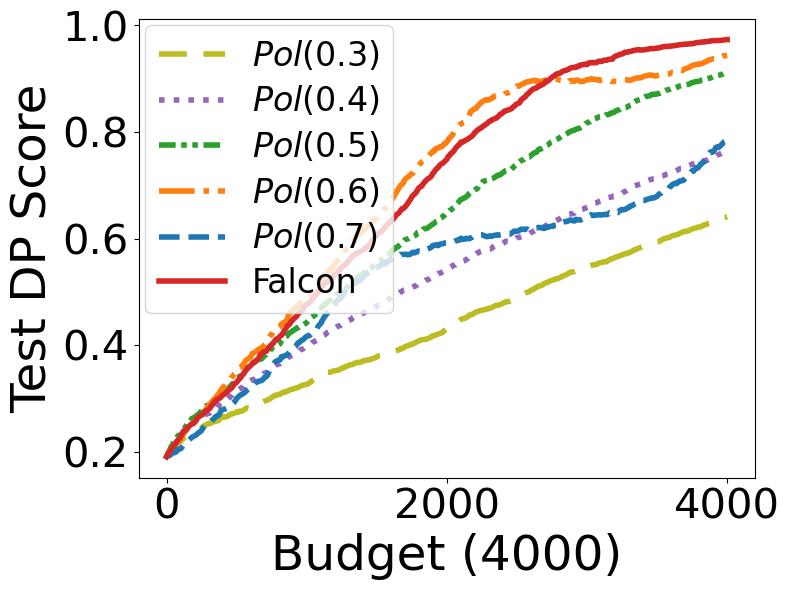

In [8]:
plt.figure(1, figsize = (8, 6))

num_labeling = np.arange(num_round+1) * num_examples
colors = ['#bcbd22', '#9467bd', '#2ca02c', '#ff7f0e', '#1f77b4', '#d62728']
linestyles = [(5, (10, 3)), "dotted", (0, (3, 1, 1, 1, 1, 1)), "dashdot", "dashed", "solid"]

for i in range(len(all_methods)):
    method = all_methods[i]
    plt.plot(num_labeling, test_fairness_avg[method], linewidth=4, label=method, color=colors[i], linestyle=linestyles[i])

plt.tick_params(labelsize=30)
plt.xlabel(f'Budget ({num_round*num_examples})', fontsize=35)
plt.ylabel(f'Test {target_fairness} Score', fontsize=35)

handles, labels = plt.gca().get_legend_handles_labels()
order = [4, 3, 2, 1, 0, 5]
order = [0, 1, 2, 3, 4, 5]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], prop={'size':24}, borderaxespad = 0.2, labelspacing=0.35)

plt.tight_layout()
plt.show()